In [73]:
import cobra
import cobra.test
import cometspy as c
import os
os.environ['GUROBI_COMETS_HOME'] = '/opt/gurobi952/linux64'
import pandas as pd
pd.set_option('display.max_rows', None) 

## This notebook shows how to make the mutualism models from newer WT metabolic models. The exception is M0, for which I do not have a WT model. If you prefer to just load the old models, see the notebook "use_old_comets_mutualism_models.ipynb"

## The current E. coli model is iML1515.  The current S. enterica model is STM_v1_0.  These will be loaded and altered to make E0 and S0.

## I have placed these files in a subdirectory "models", along with M0 (jmc_AM1_KO.xml).

## If you don't want to bother creating E0, S0, these models are also in that directory, with the suffix "E0" or "S0".

In [10]:
E_WT = cobra.io.read_sbml_model("./models/iML1515.xml")
S_WT = cobra.io.read_sbml_model("./models/STM_v1_0.xml")

# Making E0

This is very easy, all we have to do is knockout the metB gene, which is b3939. We'll make a copy of the model first so we can compare later. I won't actually save the model, but I'll have a commented-out line which would. 

In [11]:
E0 = E_WT.copy()
E0.genes.b3939

Gene identifier,b3939
Name,metB
Memory address,0x07f16907b0940
Functional,True
In 1 reaction(s),SHSL1


In [13]:
E0.genes.b3939.knock_out()
#E0.id = "E0" # if desired, change the model id
#cobra.io.write_sbml_model(E0, "./models/iML1515_E0.xml")

# compare E_WT vs. E0 growth in lactose env +- methionine

In [21]:
lactose_medium = {'EX_ca2_e': 10,
 'EX_cl_e': 10,
 'EX_cobalt2_e': 10,
 'EX_cu2_e': 10,
 'EX_fe2_e': 10,
 'EX_fe3_e': 10,
 'EX_k_e': 10,
 'EX_mg2_e': 10,
 'EX_mn2_e': 10,
 'EX_mobd_e': 10,
 'EX_ni2_e': 10,
 'EX_o2_e': 10,
 'EX_pi_e': 10,
 'EX_so4_e': 10,
 'EX_zn2_e': 10,
 'EX_nh4_e': 10,
 'EX_lcts_e': 10}
lactose_met_medium = lactose_medium.copy()
lactose_met_medium["EX_met__L_e"] = 10
E_WT.medium = lactose_medium
E0.medium = lactose_medium
print(f"E_WT growth on lac - met = {E_WT.slim_optimize(0)}")
print(f"E0 growth on lac - met = {E0.slim_optimize(0)}")
E_WT.medium = lactose_met_medium
E0.medium = lactose_met_medium
print(f"E_WT growth on lac + met = {E_WT.slim_optimize(0)}")
print(f"E0 growth on lac + met = {E0.slim_optimize(0)}")

E_WT growth on lac - met = 0.7447905301220479
E0 growth on lac - met = 0.0
E_WT growth on lac + met = 0.7541530691168099
E0 growth on lac + met = 0.7541530691168118


# Making S0

This has two steps. First, we need to force S0 to make 0.5mmol of methionine (extracellular) for each gram of growth, by altering the biomass reaction. Then, we need to make methionine transport unidirectional, so that S0 doesn't consume the methionine as it produces it.

In [23]:
S0 = S_WT.copy()
# get the metabolites
met_c = S0.metabolites.met__L_c
met_e = S0.metabolites.met__L_e
# force 0.5 mmol of met_e production for each gram of growth
biomass = S0.reactions.BIOMASS_iRR1083_metals.add_metabolites({met_c : -.5,
                                                             met_e : .5})
# make methionine transport export-only
S0.reactions.METtex.upper_bound = 0

In [24]:
ac_medium = {'EX_ca2_e': 10,
 'EX_cl_e': 10,
 'EX_cobalt2_e': 10,
 'EX_cu2_e': 10,
 'EX_fe2_e': 10,
 'EX_fe3_e': 10,
 'EX_k_e': 10,
 'EX_mg2_e': 10,
 'EX_mn2_e': 10,
 'EX_mobd_e': 10,
 'EX_ni2_e': 10,
 'EX_o2_e': 10,
 'EX_pi_e': 10,
 'EX_so4_e': 10,
 'EX_zn2_e': 10,
 'EX_nh4_e': 10,
 'EX_ac_e': 10}

# Examine secretion of S_WT vs. S0 on acetate medium:

In [40]:
S_WT.medium = ac_medium
S0.medium = ac_medium
sol_WT = S_WT.optimize()
sol_S0 = S0.optimize()
print(f"S_WT growth on ac = {sol_WT.objective_value} /hr")
print(f"S0 growth on ac = {sol_S0.objective_value} /hr")
print(f"S_WT methionine production during growth = {sol_WT.fluxes['EX_met__L_e']} mmol")
print(f"S0 methionine production during growth = {sol_S0.fluxes['EX_met__L_e']} mmol")

S_WT growth on ac = 0.08543749636964598 /hr
S0 growth on ac = 0.0776944706105925 /hr
S_WT methionine production during growth = 0.0 mmol
S0 methionine production during growth = 0.03884723530529624 mmol


# Making M0. 

The only change we need to make is to match the suffixes (from \[e] to _e)

In [41]:
M0 = cobra.io.read_sbml_model("./models/jmc_AM1_KO.xml")

In [53]:
for met in M0.metabolites:
    new_met = met.id.replace("[e]", "_e")
    met.id = new_met
for ex in M0.exchanges:
    new_id = ex.id.replace("[e]", "_e")
    new_id = new_id.replace("-", "__")
    if new_id[-2:] != "_e":
        new_id += "_e"
    ex.id = new_id
M0.repair()

In [61]:
M0.medium = {key : val for key, val in ac_medium.items() if key in [e.id for e in M0.exchanges]}
M0.exchanges.EX_mea_e.lower_bound = -10

In [63]:
M0.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
ac_e,EX_ac_e,8.45,0,0.00%
ca2_e,EX_ca2_e,6.324E-05,0,0.00%
cl_e,EX_cl_e,6.324E-05,0,0.00%
cobalt2_e,EX_cobalt2_e,4.216E-05,0,0.00%
fe2_e,EX_fe2_e,9.784E-05,0,0.00%
fe3_e,EX_fe3_e,9.486E-05,0,0.00%
k_e,EX_k_e,0.002371,0,0.00%
mea_e,EX_mea_e,6.752,0,0.00%
mg2_e,EX_mg2_e,0.0001054,0,0.00%
mn2_e,EX_mn2_e,4.216E-05,0,0.00%


In [64]:
cobra.io.write_sbml_model(M0, "./models/jmc_AM1_KO_renamed.xml")

In [65]:
M0 = cobra.io.read_sbml_model("./models/jmc_AM1_KO_renamed.xml")

In [66]:
M0.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
ac_e,EX_ac_e,8.45,0,0.00%
ca2_e,EX_ca2_e,6.324E-05,0,0.00%
cl_e,EX_cl_e,6.324E-05,0,0.00%
cobalt2_e,EX_cobalt2_e,4.216E-05,0,0.00%
fe2_e,EX_fe2_e,9.784E-05,0,0.00%
fe3_e,EX_fe3_e,9.486E-05,0,0.00%
k_e,EX_k_e,0.002371,0,0.00%
mea_e,EX_mea_e,6.752,0,0.00%
mg2_e,EX_mg2_e,0.0001054,0,0.00%
mn2_e,EX_mn2_e,4.216E-05,0,0.00%


# Now lets run a mutualism simulation:

In [67]:
E = c.model(E0)
S = c.model(S0)
M = c.model(M0)
E.open_exchanges()
S.open_exchanges()
M.open_exchanges()

In [68]:
E.initial_pop = [0, 0, 1.e-8]
S.initial_pop = [0, 0, 1.e-8]
M.initial_pop = [0, 0, 1.e-8]
E.obj_style = "MAXIMIZE_OBJECTIVE_FLUX"
S.obj_style =  "MAXIMIZE_OBJECTIVE_FLUX"
M.obj_style =  "MAXIMIZE_OBJECTIVE_FLUX"

In [70]:
l = c.layout([E,S,M])
base_nutrients = ["ca2_e", "cl_e", "cobalt2_e", "cu2_e","fe2_e", "fe3_e", "k_e","mg2_e",
                  "mn2_e", "mobd_e", "ni2_e", "o2_e", "pi_e", "so4_e", "zn2_e"]
for nutrient in base_nutrients:
    l.set_specific_metabolite(nutrient, 1000)
l.set_specific_metabolite("lcts_e", 0.000278)
l.set_specific_metabolite("mea_e", 0.0015)

In [71]:
p = c.params()
p.set_param("defaultKm", 0.00001) # M 
p.set_param("defaultVmax", 10) #mmol/gDw/hr
p.set_param("maxCycles", 200)
p.set_param("timeStep", 1)

In [74]:
sim = c.comets(l, p)
sim.run()


Running COMETS simulation ...
Done!


<AxesSubplot:xlabel='cycle'>

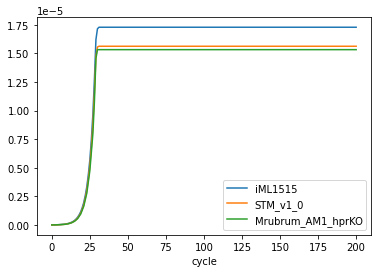

In [75]:
sim.total_biomass.plot(x = "cycle")